In [246]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [247]:
data_dirpath = Path('../..') / 'data'
output_dirpath = data_dirpath / 'output/imputation'
openml_dirpath = data_dirpath / 'openml'
fig_dirpath = output_dirpath / 'fig'
fig_dirpath.mkdir(parents=True, exist_ok=True)

methods = ['meanmode', 'knn', 'rf']
llm_models = [
  'meta-llama/Llama-2-13b-chat-hf', 
  'meta-llama/Llama-2-70b-chat-hf', 
  'mistralai/Mistral-7B-Instruct-v0.2', 
  'mistralai/Mixtral-8x7B-Instruct-v0.1'
]
[methods.append(f'llm/{model}') for model in llm_models]

[None, None, None, None]

In [248]:
def fetch_openml_description_length(openml_dirpath: Path):
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    dataset_length_dict = {}
    for openml_id in dataset_list['did']:
        dataset_description_filepath = openml_dirpath / f'{openml_id}/description.txt'
        with open(dataset_description_filepath) as f:
            dataset_description = f.read()
            dataset_description_length = len(dataset_description)
            dataset_length_dict[openml_id] = dataset_description_length
    return dataset_length_dict

dataset_length_dict = fetch_openml_description_length(openml_dirpath)

In [249]:
def fetch_openml_num_features(openml_dirpath: Path):
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    dataset_num_features_dict = { openml_id: n_features-1 for openml_id, n_features in zip(dataset_list['did'], dataset_list['NumberOfFeatures']) }
    return dataset_num_features_dict

dataset_num_features_dict = fetch_openml_num_features(openml_dirpath)

In [250]:
def fetch_openml_category(openml_dirpath: Path):
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    # update natural language processing -> NLP
    dataset_list['category (manually)'] = dataset_list['category (manually)'].replace('natural language processing', 'NLP')
    dataset_category_dict = { openml_id: category for openml_id, category in zip(dataset_list['did'], dataset_list['category (manually)']) }
    return dataset_category_dict

dataset_category_dict = fetch_openml_category(openml_dirpath)

In [251]:
rmse_df = pd.DataFrame(columns=['method', 'openml_id', 'openml_desc_len', 'category', 'n_features', 'rmse'])
macro_f1_df = pd.DataFrame(columns=['method', 'openml_id', 'openml_desc_len', 'category', 'n_features', 'macro_f1'])
downstream_df = pd.DataFrame(columns=['method', 'openml_id', 'openml_desc_len', 'category', 'n_features', 'accuracy', 'macro_f1'])
corrected_methods = { 
    'meanmode': 'Mean/Mode', 
    'knn': '$k$-NN', 
    'rf': 'Random Forest', 
    'llm/meta-llama/Llama-2-13b-chat-hf': 'LLaMA 2 13B Chat', 
    'llm/meta-llama/Llama-2-70b-chat-hf': 'LLaMA 2 70B Chat', 
    'llm/mistralai/Mistral-7B-Instruct-v0.2': 'Mistral 7B Instruct',
    'llm/mistralai/Mixtral-8x7B-Instruct-v0.1': 'Mixtral 8x7B Instruct'
}

for method in methods:
    method_output_dirpath = output_dirpath / method
    method_imputation_results_filepath = method_output_dirpath / f'imputation_complete.csv'
    method_imputation_results = pd.read_csv(method_imputation_results_filepath, header=0)
    method_imputation_results = method_imputation_results.drop(['timestamp'], axis=1)
    method_imputation_results['method_id'] = list(corrected_methods.keys()).index(method)
    method_imputation_results['method'] = corrected_methods[method]
    method_imputation_results['openml_desc_len'] = method_imputation_results['openml_id'].map(dataset_length_dict)
    method_imputation_results['category'] = method_imputation_results['openml_id'].map(dataset_category_dict)
    method_imputation_results['n_features'] = method_imputation_results['openml_id'].map(dataset_num_features_dict)

    method_downstream_results_filepath = method_output_dirpath / f'downstream_complete.csv'
    method_downstream_results = pd.read_csv(method_downstream_results_filepath, header=0)
    method_downstream_results = method_downstream_results.drop(['timestamp'], axis=1)
    method_downstream_results['method'] = corrected_methods[method]
    method_downstream_results['openml_desc_len'] = method_downstream_results['openml_id'].map(dataset_length_dict)
    method_downstream_results['category'] = method_downstream_results['openml_id'].map(dataset_category_dict)
    method_downstream_results['n_features'] = method_downstream_results['openml_id'].map(dataset_num_features_dict)
    
    rmse_df = pd.concat([rmse_df, method_imputation_results.drop(['macro_f1', 'missing_column_name'], axis=1).dropna()])
    macro_f1_df = pd.concat([macro_f1_df, method_imputation_results.drop(['rmse', 'missing_column_name'], axis=1).dropna()])
    downstream_df = pd.concat([downstream_df, method_downstream_results])
    
rmse_df = rmse_df.groupby(['method', 'method_id', 'openml_id', 'openml_desc_len', 'category', 'missingness', 'missing_column_type']).mean().reset_index()
rmse_df = rmse_df.sort_values('method_id').reset_index(drop=True)

macro_f1_df = macro_f1_df.groupby(['method', 'method_id', 'openml_id', 'openml_desc_len', 'category', 'missingness', 'missing_column_type']).mean().reset_index()
macro_f1_df = macro_f1_df.sort_values('method_id').reset_index(drop=True)


/var/folders/mr/qc9n5qqn4jjgn6jh4mpcfsgm0000gn/T/ipykernel_23669/741647948.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, method_imputation_results.drop(['macro_f1', 'missing_column_name'], axis=1).dropna()])
/var/folders/mr/qc9n5qqn4jjgn6jh4mpcfsgm0000gn/T/ipykernel_23669/741647948.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  macro_f1_df = pd.concat([macro_f1_df, method_imputation_results.drop(['rmse', 'missing_column_name'], axis=1).dropna()])
/var/f

In [252]:
rmse_df

,method,method_id,openml_id,openml_desc_len,category,missingness,missing_column_type,n_features,rmse,n_missing_values
0,Mean/Mode,0.0,1489,4799,NLP,MAR,numerical,5.0,0.278109,16.666667
1,Mean/Mode,0.0,1068,2532,engineering,MAR,numerical,21.0,0.181440,18.666667
2,Mean/Mode,0.0,1067,2509,computer science,MAR,numerical,21.0,0.241089,17.333333
3,Mean/Mode,0.0,1063,2473,computer science,MAR,numerical,21.0,0.211460,17.333333
4,Mean/Mode,0.0,1050,1235,engineering,MAR,numerical,37.0,0.146820,17.000000
...,...,...,...,...,...,...,...,...,...,...
342,Mixtral 8x7B Instruct,6.0,1480,1631,medicine,MAR,numerical,10.0,0.448734,18.500000
343,Mixtral 8x7B Instruct,6.0,1478,3817,computer vision,MAR,numerical,561.0,0.740620,16.666667
344,Mixtral 8x7B Instruct,6.0,1475,838,computer science,MAR,numerical,51.0,0.231200,16.666667
345,Mixtral 8x7B Instruct,6.0,1462,1045,computer vision,MAR,numerical,4.0,0.359424,16.666667


In [253]:
macro_f1_df

,method,method_id,openml_id,openml_desc_len,category,missingness,missing_column_type,n_features,macro_f1,n_missing_values
0,Mean/Mode,0.0,469,689,medicine,MAR,categorical,4.0,0.553072,16.666667
1,Mean/Mode,0.0,40978,1222,NLP,MAR,categorical,1558.0,1.000000,16.666667
2,Mean/Mode,0.0,40975,2152,business,MAR,categorical,6.0,0.497340,17.333333
3,Mean/Mode,0.0,40670,1747,biology,MAR,categorical,180.0,0.768501,17.000000
4,Mean/Mode,0.0,40668,793,board game,MAR,categorical,42.0,0.485475,16.666667
...,...,...,...,...,...,...,...,...,...,...
97,Mixtral 8x7B Instruct,6.0,50,969,board game,MAR,categorical,9.0,0.269040,17.333333
98,Mixtral 8x7B Instruct,6.0,46,1852,biology,MAR,categorical,60.0,0.279327,16.666667
99,Mixtral 8x7B Instruct,6.0,31,1443,economics,MAR,categorical,20.0,0.180392,19.000000
100,Mixtral 8x7B Instruct,6.0,3,3178,board game,MAR,categorical,36.0,0.324447,16.666667


In [254]:
llm_rmse_df = rmse_df.loc[rmse_df['method'].isin(['LLaMA 2 13B Chat', 'LLaMA 2 70B Chat', 'Mistral 7B Instruct', 'Mixtral 8x7B Instruct'])]
llm_rmse_df = llm_rmse_df.loc[:, ['method', 'category', 'rmse', 'openml_desc_len']]
llm_rmse_df = llm_rmse_df.reset_index(drop=True)
llm_rmse_df

,method,category,rmse,openml_desc_len
0,LLaMA 2 13B Chat,computer vision,0.279860,1057
1,LLaMA 2 13B Chat,psychology,0.310447,1013
2,LLaMA 2 13B Chat,NLP,6.375428,2587
3,LLaMA 2 13B Chat,computer science,0.198163,838
4,LLaMA 2 13B Chat,medicine,13.404652,1395
...,...,...,...,...
183,Mixtral 8x7B Instruct,medicine,0.448734,1631
184,Mixtral 8x7B Instruct,computer vision,0.740620,3817
185,Mixtral 8x7B Instruct,computer science,0.231200,838
186,Mixtral 8x7B Instruct,computer vision,0.359424,1045


In [255]:
llm_macro_f1_df = macro_f1_df.loc[macro_f1_df['method'].isin(['LLaMA 2 13B Chat', 'LLaMA 2 70B Chat', 'Mistral 7B Instruct', 'Mixtral 8x7B Instruct'])]
llm_macro_f1_df = llm_macro_f1_df.loc[:, ['method', 'category', 'macro_f1', 'openml_desc_len']]
llm_macro_f1_df = llm_macro_f1_df.reset_index(drop=True)
llm_macro_f1_df

,method,category,macro_f1,openml_desc_len
0,LLaMA 2 13B Chat,board game,0.217813,3178
1,LLaMA 2 13B Chat,social sciences,0.416460,2434
2,LLaMA 2 13B Chat,economics,0.180392,1443
3,LLaMA 2 13B Chat,business,0.369600,2152
4,LLaMA 2 13B Chat,biology,0.503265,1747
5,LLaMA 2 13B Chat,board game,0.350201,793
6,LLaMA 2 13B Chat,NLP,0.302919,2501
7,LLaMA 2 13B Chat,medicine,0.365942,1631
8,LLaMA 2 13B Chat,business,0.190476,2569
9,LLaMA 2 13B Chat,medicine,0.332752,689


# Imputation quality

## Normalized Root Mean Squared Error (NRMSE)

$$
\text{NRMSE} = \frac{\text{RMSE}}{|x_{\max} - x_{\min}|}
$$
, where $x_{\max}$ and $x_{\min}$ are the maximum and minimum value of the observed (ground truth) values, and
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2}
$$
, where $x_i$ represents the observed (ground truth) value and $\hat{x}_i$ represents the to-be-imputed value.

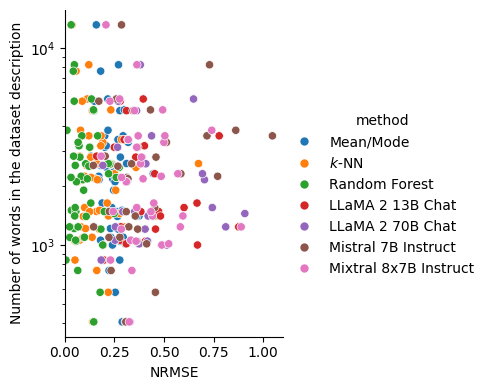

In [256]:
g = sns.relplot(
    data=rmse_df, x='rmse', y='openml_desc_len', hue='method', 
    height=4, aspect=0.9
)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Number of words in the dataset description')
g.ax.set_yscale('log')
g.ax.set_xlim(0.0, 1.1)
g.fig.savefig(output_dirpath / 'fig/nrmse-desclength-all.pdf', bbox_inches='tight')

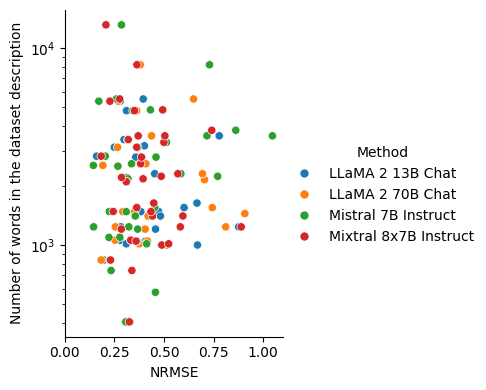

In [257]:
g = sns.relplot(
    data=llm_rmse_df, x='rmse', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Number of words in the dataset description')
g.legend.set_title('Method')
g.ax.set_yscale('log')
g.ax.set_xlim(0, 1.1)
g.fig.savefig(output_dirpath / 'fig/nrmse-desclength-llm.pdf', bbox_inches='tight')

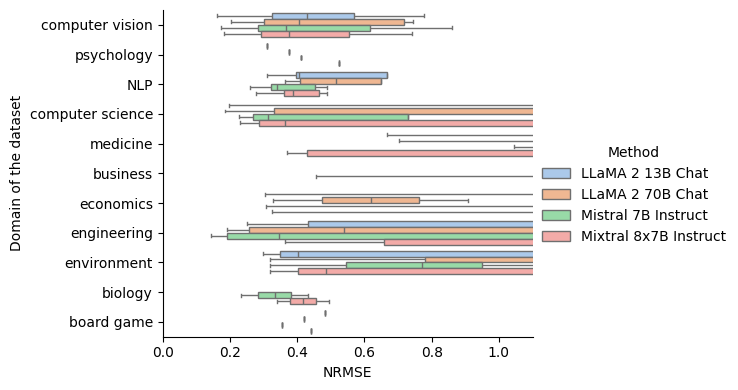

In [258]:
g = sns.catplot(
  data=llm_rmse_df, x="rmse", y="category", hue="method", palette='pastel',
  kind="box", height=4, aspect=1.5,
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/nrmse-domain-llm.pdf', bbox_inches='tight')

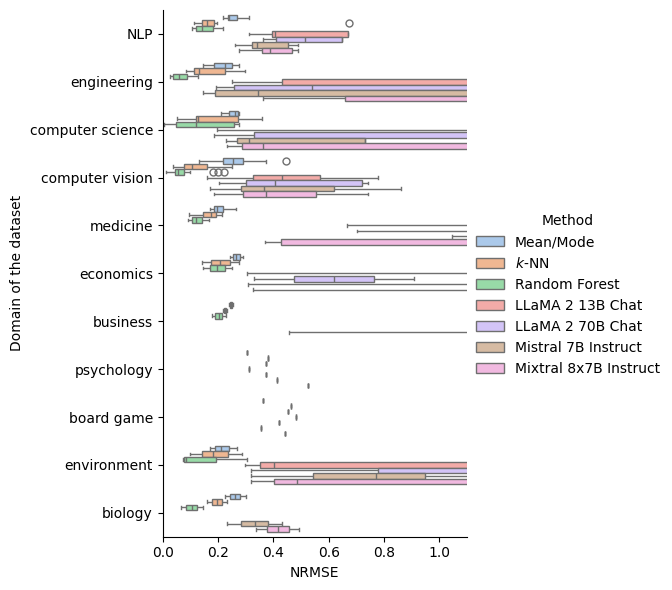

In [259]:
g = sns.catplot(
  data=rmse_df, x="rmse", y="category", hue="method", palette='pastel',
  kind="box", height=6, aspect=0.9
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/nrmse-domain-all.pdf', bbox_inches='tight')

## $F_1$ score

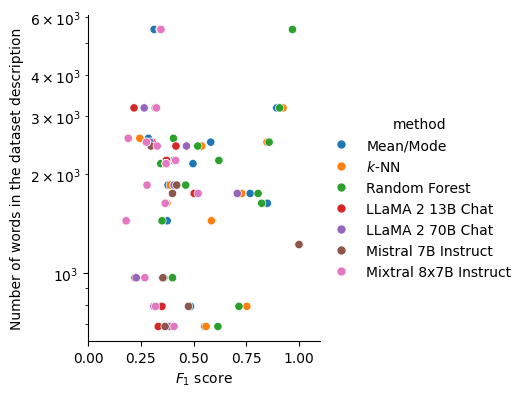

In [260]:
g = sns.relplot(
    data=macro_f1_df, x='macro_f1', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Number of words in the dataset description')
g.ax.set_yscale('log')
g.ax.set_xlim(0, 1.1)
g.fig.savefig(output_dirpath / 'fig/f1-desclength-all.pdf', bbox_inches='tight')

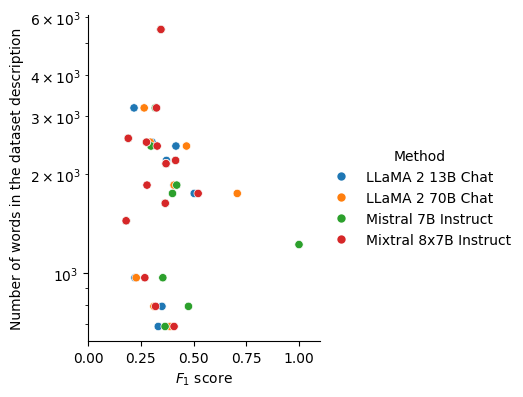

In [261]:
g = sns.relplot(
    data=llm_macro_f1_df, x='macro_f1', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Number of words in the dataset description')
g.legend.set_title('Method')
g.ax.set_yscale('log')
g.ax.set_xlim(0, 1.1)
g.fig.savefig(output_dirpath / 'fig/f1-desclength-llm.pdf', bbox_inches='tight')

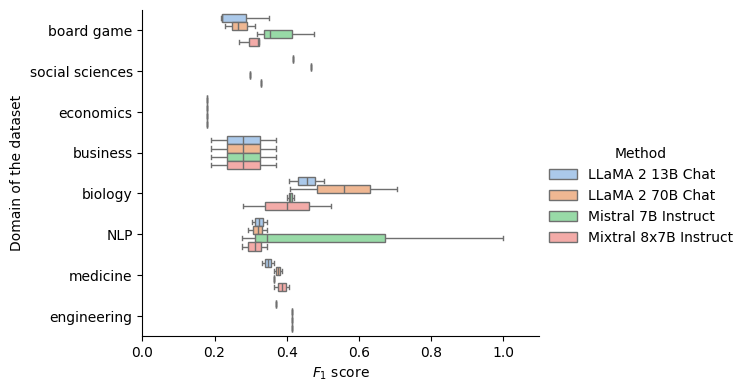

In [262]:
g = sns.catplot(
  data=llm_macro_f1_df, x="macro_f1", y="category", hue="method", palette='pastel',
  kind="box", height=4, aspect=1.5,
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/f1-domain-llm.pdf', bbox_inches='tight')

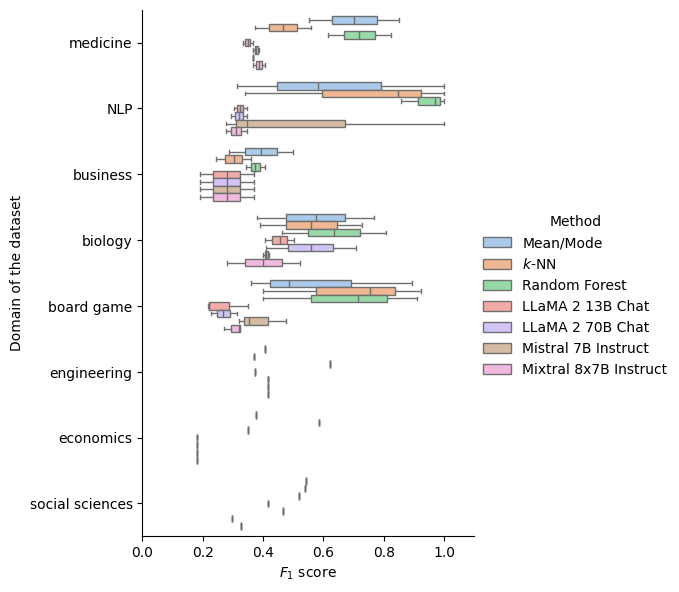

In [263]:
g = sns.catplot(
  data=macro_f1_df, x="macro_f1", y="category", hue="method", palette='pastel',
  kind="box", height=6, aspect=0.9
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/f1-domain-all.pdf', bbox_inches='tight')